This notebook will build LSTM models to predict daily stock prices using technical analysis data.

# Import libraries

In [ ]:
# !pip install schedule scikit-learn matplotlib pandas numpy

In [ ]:
# !pip install tensorflow==2.12

In [ ]:
# !pip install keras_tuner

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras_tuner import HyperModel, RandomSearch, HyperParameters, Objective
# from kerastuner.tuners import RandomSearch

In [ ]:
# !"c:/Users/beani/my_files/GIT/projects/tayoso github projects/stock_forecast/.venvs/stock-forecast-CV-iGpoJ-py3.11/Scripts/python.exe" -m pip install ipykernel -U --force-reinstall

# Basic LSTM for Apple Stock

In [ ]:
# model = Sequential()
# Creates a linear stack of layers where we can add one layer at a time.

# LSTM Layers:

# python
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# First LSTM layer with 50 units (neurons)

# return_sequences=True means it outputs the full sequence (needed for stacking LSTM layers)

# input_shape=(X_train.shape[1], 1) specifies:

# X_train.shape[1]: Number of timesteps in each sample

# 1: Number of features at each timestep (just closing price in this case)

# python
# model.add(Dropout(0.2))
# Dropout layer randomly sets 20% of inputs to 0 during training

# Helps prevent overfitting by making the network more robust

# python
# model.add(LSTM(units=50, return_sequences=True))
# Second LSTM layer (also with 50 units)

# Still returns sequences for the next layer

# python
# model.add(LSTM(units=50))
# Third LSTM layer (50 units)

# No return_sequences (default False) - outputs single value per sample

# python
# model.add(Dense(units=1))
# Final dense layer with 1 unit (outputs the predicted value)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data from 2010-01-04 00:00:00 to 2020-12-30 00:00:00
Price          Close
Ticker          AAPL
Date                
2010-01-04  6.440331
2010-01-05  6.451466
2010-01-06  6.348847
2010-01-07  6.337109
2010-01-08  6.379241


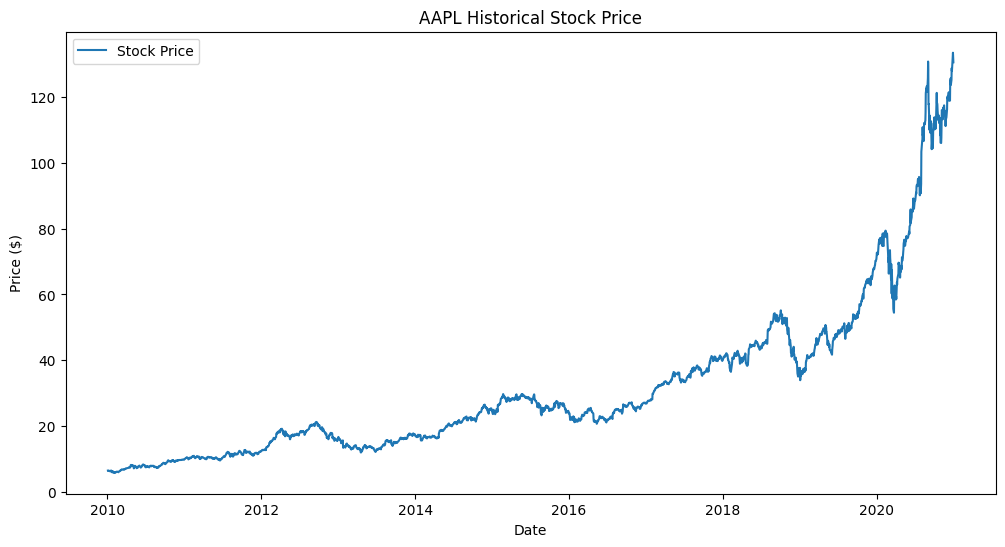

Epoch 1/100
61/61 [==============================] - 14s 117ms/step - loss: 9.5329e-04 - val_loss: 1.9231e-04
Epoch 2/100
61/61 [==============================] - 5s 79ms/step - loss: 2.0292e-04 - val_loss: 1.8939e-04
Epoch 3/100
61/61 [==============================] - 5s 85ms/step - loss: 1.7736e-04 - val_loss: 1.8426e-04
Epoch 4/100
61/61 [==============================] - 5s 85ms/step - loss: 1.7284e-04 - val_loss: 2.0344e-04
Epoch 5/100
61/61 [==============================] - 5s 90ms/step - loss: 1.7620e-04 - val_loss: 3.7657e-04
Epoch 6/100
61/61 [==============================] - 5s 85ms/step - loss: 1.4347e-04 - val_loss: 1.7966e-04
Epoch 7/100
61/61 [==============================] - 5s 90ms/step - loss: 1.2921e-04 - val_loss: 3.0567e-04
Epoch 8/100
61/61 [==============================] - 5s 81ms/step - loss: 1.3694e-04 - val_loss: 1.6409e-04
Epoch 9/100
61/61 [==============================] - 5s 85ms/step - loss: 1.1990e-04 - val_loss: 1.6416e-04
Epoch 10/100
61/61 [======

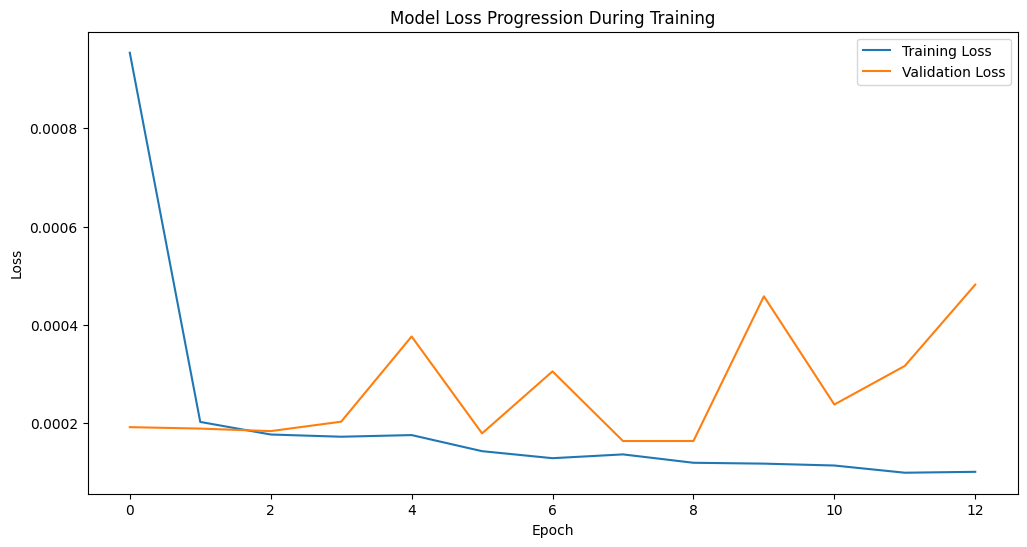

16/16 [==============================] - 2s 27ms/step
Root Mean Squared Error: 5.09


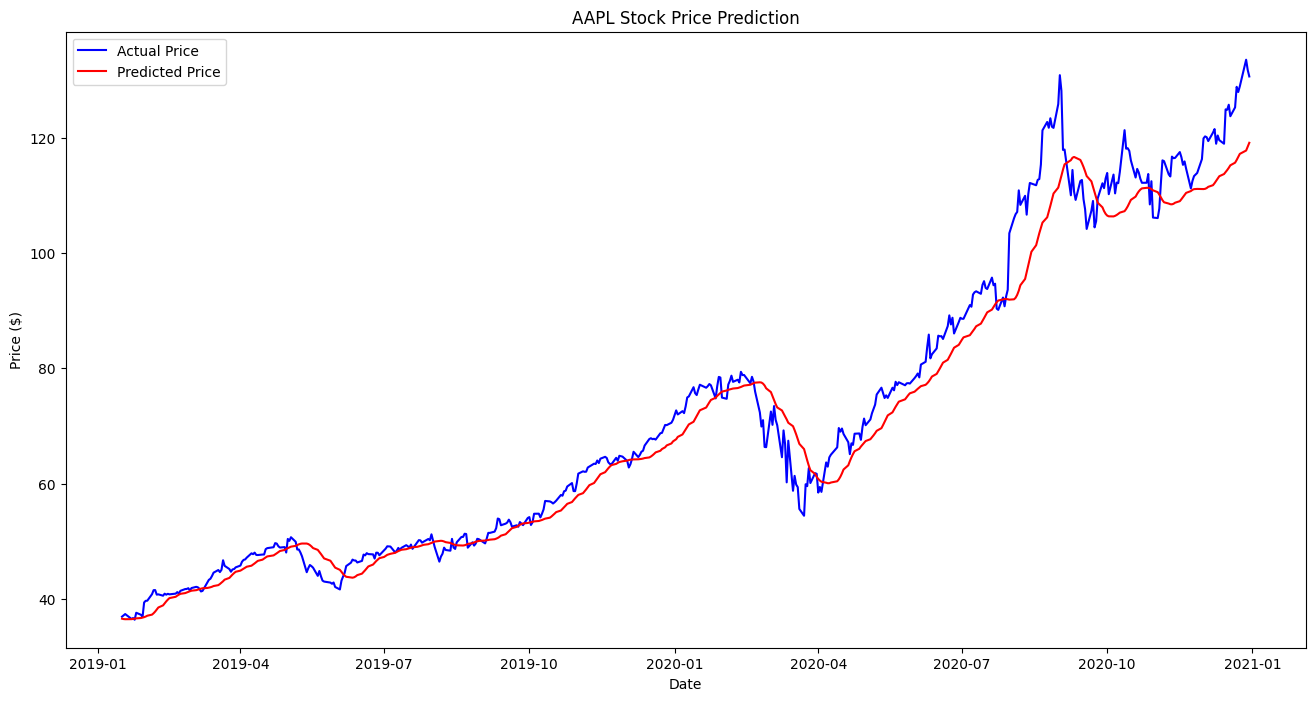

1/1 [==============================] - 0s 41ms/step


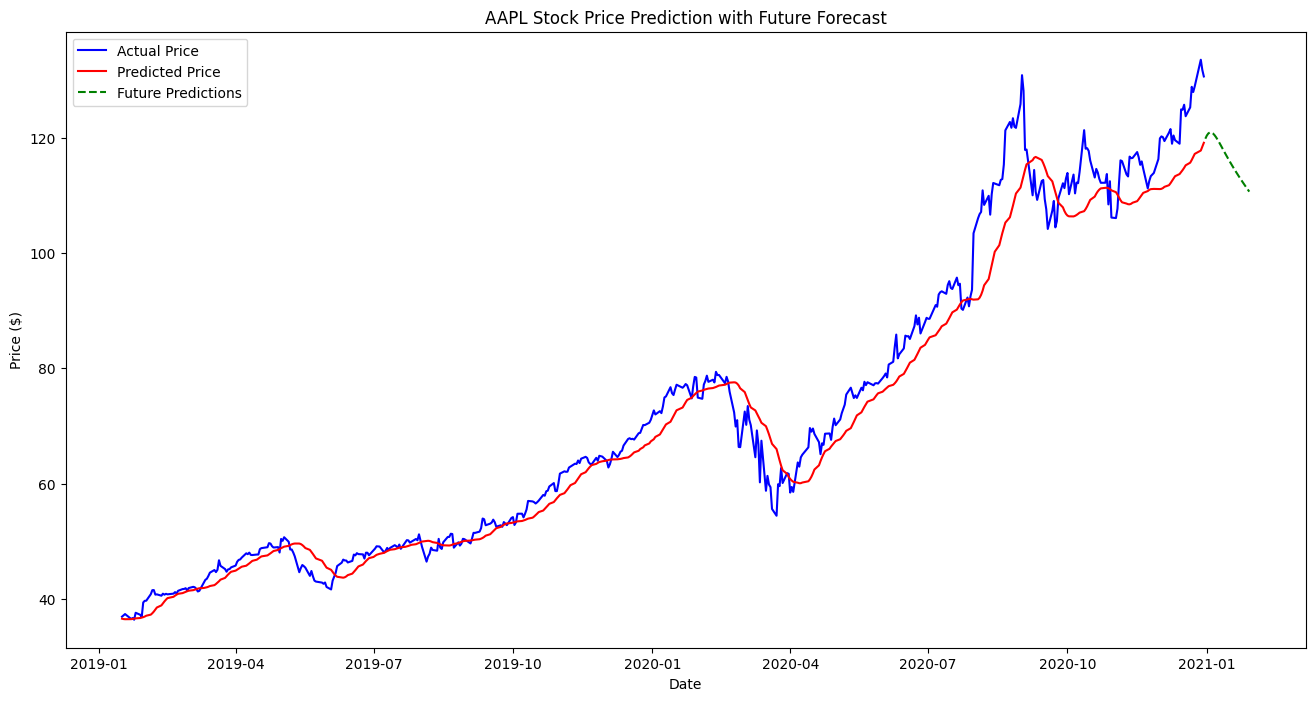

In [ ]:
# Step 1: Data Collection from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data from Yahoo Finance
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Parameters - you can change these
TICKER = 'AAPL'  # Apple stock
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'

# Fetch the data
df = fetch_stock_data(TICKER, START_DATE, END_DATE)

# We'll use the 'Close' price for our prediction
df = df[['Close']]

# Check data
print(f"Data from {df.index[0]} to {df.index[-1]}")
print(df.head())

# Visualize the data
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Stock Price')
plt.title(f'{TICKER} Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Step 2: Data Preprocessing
# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Create training and test sets (80-20 split)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare time series data for LSTM
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Using 60 days of history to predict next day
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 3: Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 4: Train the Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 5: Make Predictions and Evaluate
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'Root Mean Squared Error: {rmse:.2f}')

# Visualize Results
plt.figure(figsize=(16,8))
plt.plot(df.index[train_size+time_steps:], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[train_size+time_steps:], predictions, label='Predicted Price', color='red')
plt.title(f'{TICKER} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Step 6: Future Predictions
def predict_future(model, data, time_steps, future_days):
    future_predictions = []
    current_batch = data[-time_steps:].reshape((1, time_steps, 1))
    
    for i in range(future_days):
        current_pred = model.predict(current_batch)[0]
        future_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
    
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
    return future_predictions

future_days = 30
future_predictions = predict_future(model, scaled_data, time_steps, future_days)

# Plot future predictions
future_dates = pd.date_range(start=df.index[-1], periods=future_days+1)[1:]
plt.figure(figsize=(16,8))
plt.plot(df.index[train_size+time_steps:], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[train_size+time_steps:], predictions, label='Predicted Price', color='red')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='green', linestyle='--')
plt.title(f'{TICKER} Stock Price Prediction with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


Data from 2010-01-04 00:00:00 to 2020-12-30 00:00:00
Price          Close
Ticker          NVDA
Date                
2010-01-04  0.423884
2010-01-05  0.430073
2010-01-06  0.432824
2010-01-07  0.424342
2010-01-08  0.425259


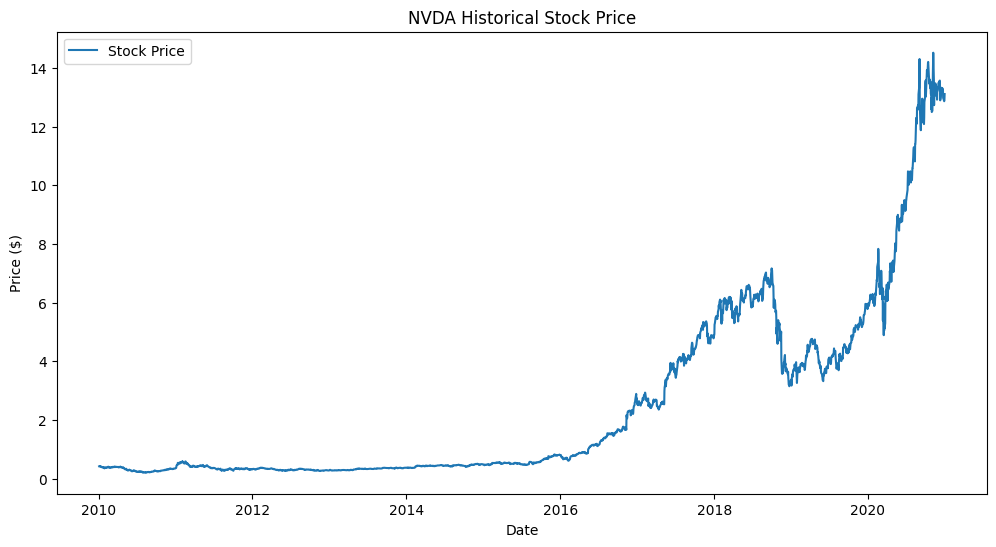

Epoch 1/100
61/61 [==============================] - 14s 118ms/step - loss: 8.3186e-04 - val_loss: 0.0013
Epoch 2/100
61/61 [==============================] - 5s 87ms/step - loss: 1.6294e-04 - val_loss: 8.8936e-04
Epoch 3/100
61/61 [==============================] - 5s 90ms/step - loss: 1.9713e-04 - val_loss: 0.0012
Epoch 4/100
61/61 [==============================] - 6s 93ms/step - loss: 1.3904e-04 - val_loss: 0.0013
Epoch 5/100
61/61 [==============================] - 5s 82ms/step - loss: 1.4617e-04 - val_loss: 5.3568e-04
Epoch 6/100
61/61 [==============================] - 5s 89ms/step - loss: 1.4129e-04 - val_loss: 5.0014e-04
Epoch 7/100
61/61 [==============================] - 5s 87ms/step - loss: 1.3692e-04 - val_loss: 0.0012
Epoch 8/100
61/61 [==============================] - 6s 97ms/step - loss: 1.2318e-04 - val_loss: 4.2556e-04
Epoch 9/100
61/61 [==============================] - 6s 91ms/step - loss: 1.3112e-04 - val_loss: 4.2643e-04
Epoch 10/100
61/61 [======================

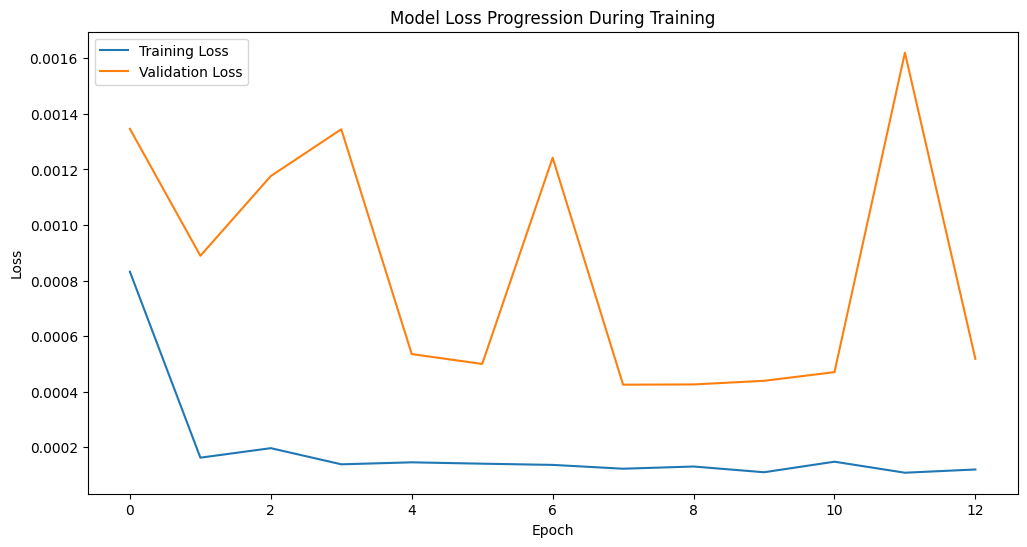

16/16 [==============================] - 2s 31ms/step
Root Mean Squared Error: 0.90


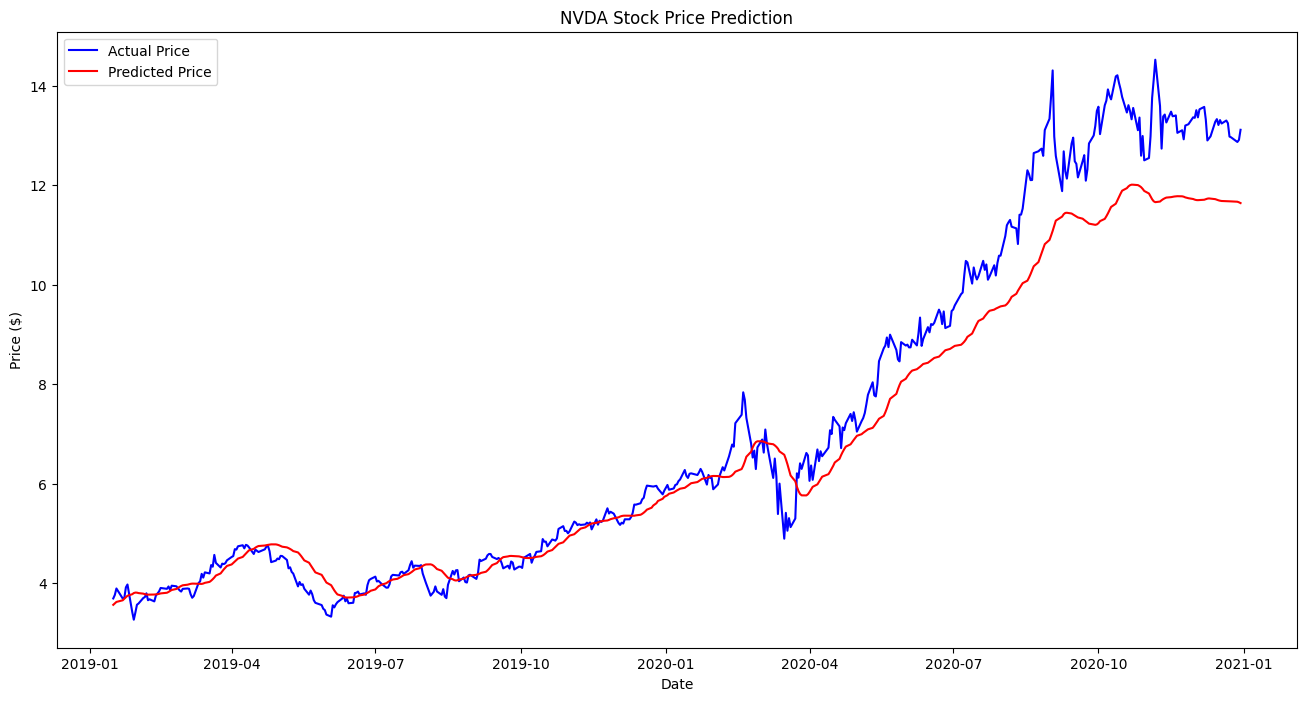

1/1 [==============================] - 0s 33ms/step


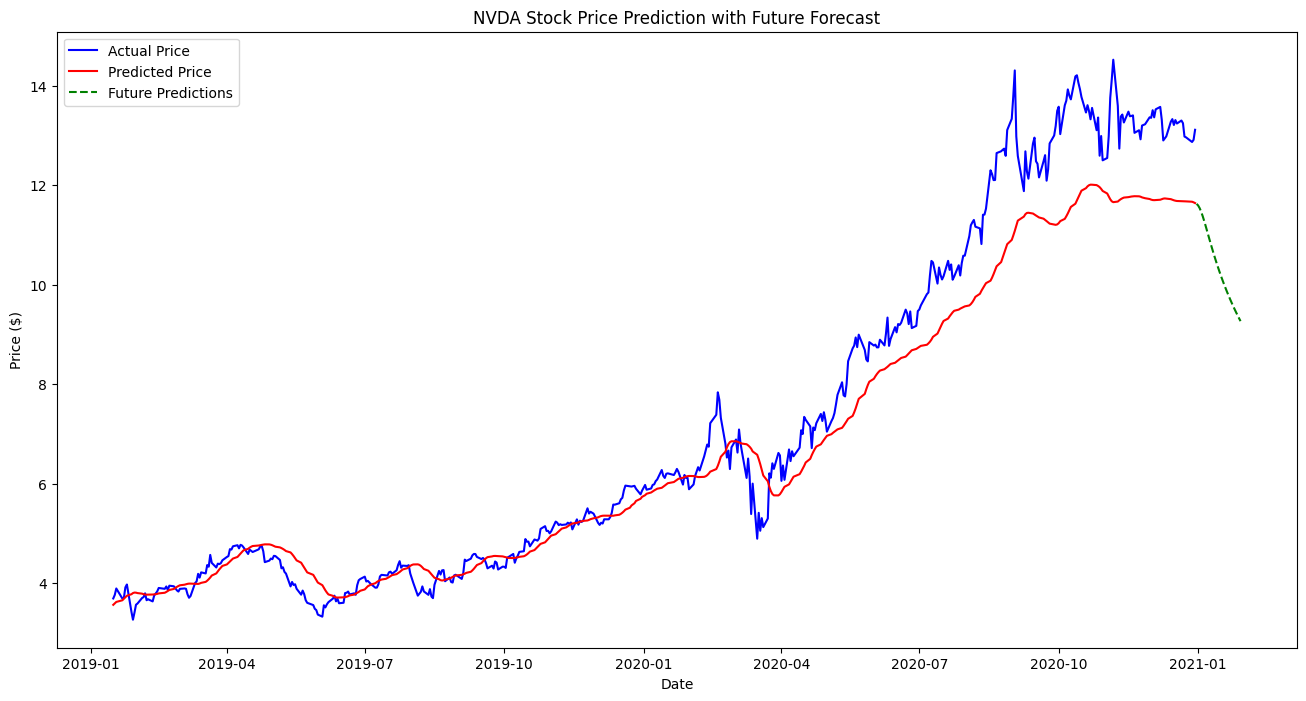

In [13]:
# Do same for NVIDIA

TICKER = 'NVDA'  # nvidia stock
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'

# Fetch the data
df = fetch_stock_data(TICKER, START_DATE, END_DATE)

# We'll use the 'Close' price for our prediction
df = df[['Close']]

# Check data
print(f"Data from {df.index[0]} to {df.index[-1]}")
print(df.head())


# Visualize the data
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Stock Price')
plt.title(f'{TICKER} Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Create training and test sets (80-20 split)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare time series data for LSTM
def create_dataset(data, time_steps=60):
    """
    Create dataset for LSTM model
    """
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Using 60 days of history to predict next day
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make Predictions and Evaluate
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'Root Mean Squared Error: {rmse:.2f}')


# Visualize Results
plt.figure(figsize=(16,8))
plt.plot(df.index[train_size+time_steps:], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[train_size+time_steps:], predictions, label='Predicted Price', color='red')
plt.title(f'{TICKER} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


# Future Predictions
def predict_future(model, data, time_steps, future_days):
    """
    Predict future stock prices
    """
    future_predictions = []
    current_batch = data[-time_steps:].reshape((1, time_steps, 1))
    
    for i in range(future_days):
        current_pred = model.predict(current_batch)[0]
        future_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
    
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
    return future_predictions


future_days = 30
future_predictions = predict_future(model, scaled_data, time_steps, future_days)


# Plot future predictions
future_dates = pd.date_range(start=df.index[-1], periods=future_days+1)[1:]
plt.figure(figsize=(16,8))
plt.plot(df.index[train_size+time_steps:], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[train_size+time_steps:], predictions, label='Predicted Price', color='red')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='green', linestyle='--')
plt.title(f'{TICKER} Stock Price Prediction with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Enhanced LSTM for NVDA Stock (Work In Progress)

Key Improvements:
Attention Mechanism:
Added an attention layer that helps the model focus on important time steps for capturing sudden price spikes/dips

Hyperparameter Tuning:
Used Keras Tuner to automatically find optimal:
Number of LSTM units, Dropout rates, Learning rate, Searches through 10 different configurations, 

Weighted Loss Function:
Implemented exponential weighting that gives more importance to recent data points, Helps reduce prediction lag by penalizing recent errors more heavily

Enhanced Features:
Added technical indicators (SMA, RSI, Daily Returns), Multi-feature input improves model's understanding of market conditions, Better Normalization: Separate scalers for each feature to preserve their distributions, Proper inverse transform for accurate price predictions

Trial 10 Complete [00h 00m 20s]
val_loss: 7.857312311898568e-07

Best val_loss So Far: 7.582192438349011e-07
Total elapsed time: 00h 38m 06s
Epoch 1/100
54/54 [==============================] - 5s 39ms/step - loss: 2.8464e-08 - mae: 0.0045 - val_loss: 1.0775e-06 - val_mae: 0.0244
Epoch 2/100
54/54 [==============================] - 1s 27ms/step - loss: 2.9430e-08 - mae: 0.0047 - val_loss: 7.5616e-07 - val_mae: 0.0214
Epoch 3/100
54/54 [==============================] - 1s 27ms/step - loss: 3.1756e-08 - mae: 0.0049 - val_loss: 1.0336e-06 - val_mae: 0.0240
Epoch 4/100
54/54 [==============================] - 1s 27ms/step - loss: 2.2879e-08 - mae: 0.0038 - val_loss: 1.5945e-06 - val_mae: 0.0303
Epoch 5/100
54/54 [==============================] - 1s 28ms/step - loss: 2.3805e-08 - mae: 0.0040 - val_loss: 1.1469e-06 - val_mae: 0.0253
Epoch 6/100
54/54 [==============================] - 1s 27ms/step - loss: 2.8484e-08 - mae: 0.0047 - val_loss: 8.0728e-07 - val_mae: 0.0228
Epoch 7/100
16/16 [

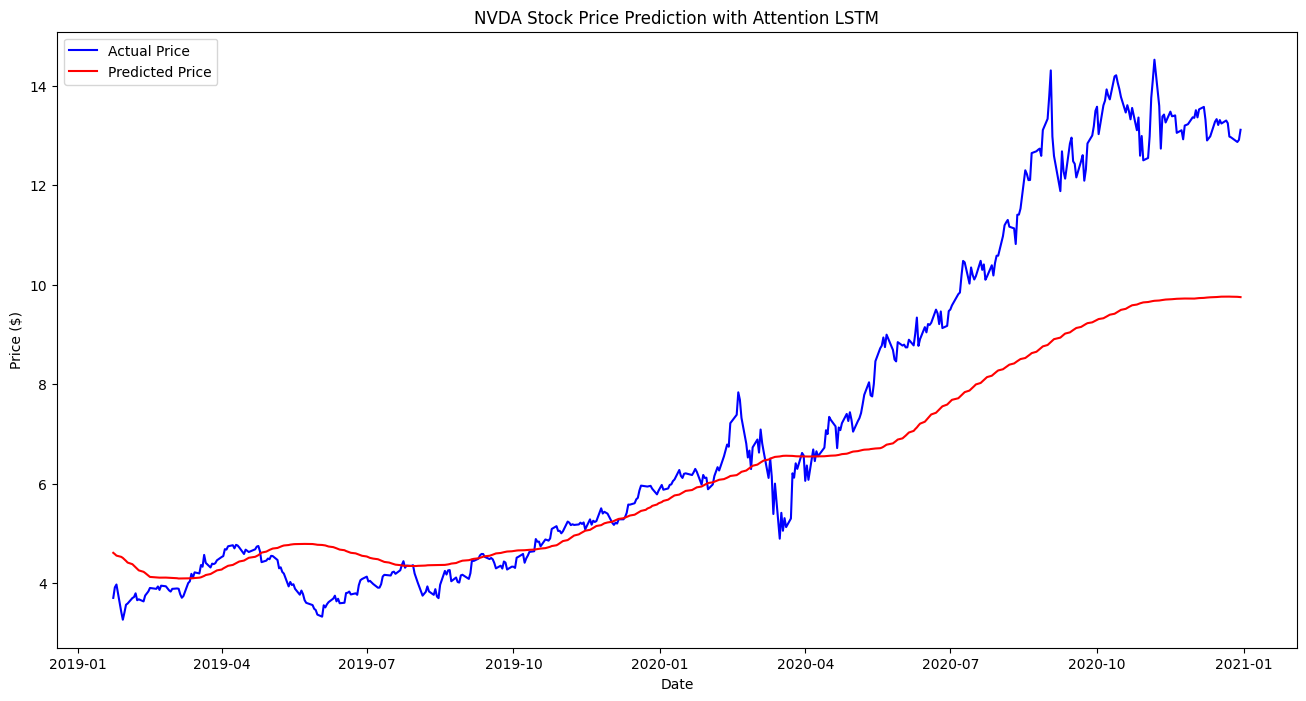

1/1 [==============================] - 0s 17ms/step


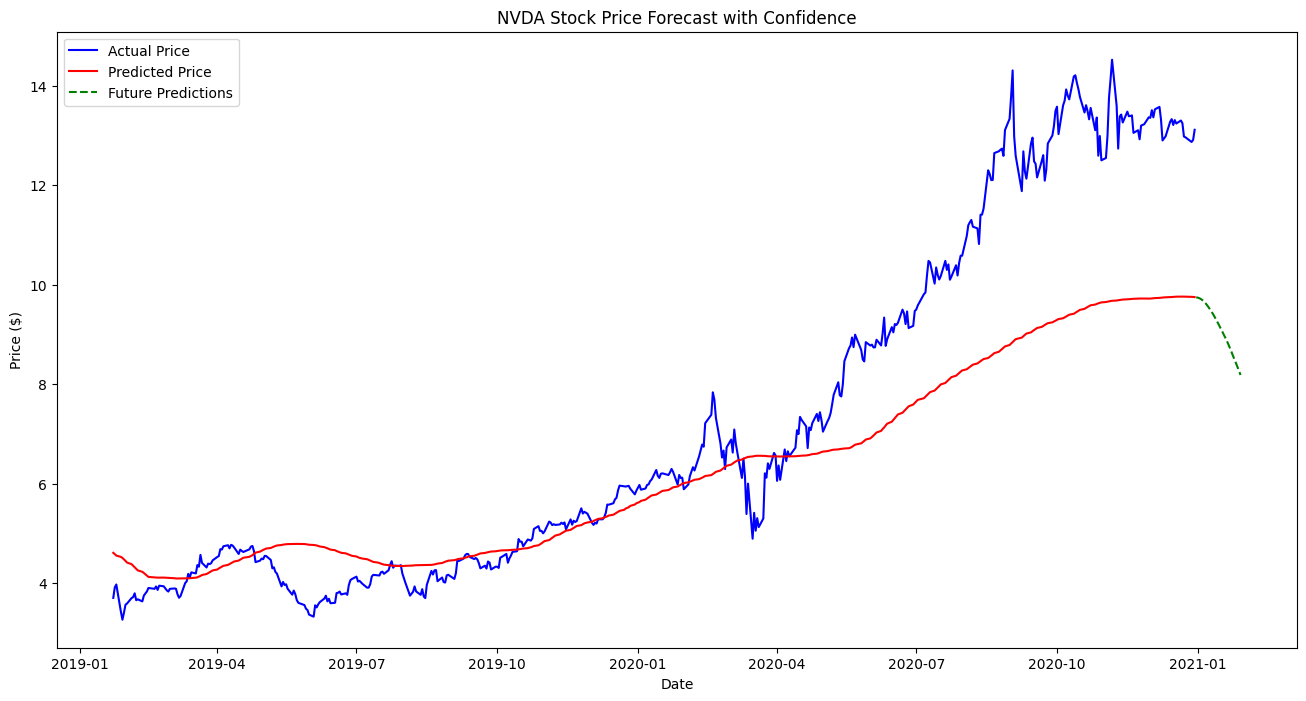

In [5]:
# Configuration
TICKER = 'NVDA'  # NVIDIA stock
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
TIME_STEPS = 60
FUTURE_DAYS = 30

# 1. Enhanced Data Fetching and Preparation
def fetch_stock_data(ticker, start_date, end_date):
    """Fetch data with additional features"""
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Add technical indicators
    data['SMA_20'] = data['Close'].rolling(20).mean()
    data['RSI_14'] = 100 - (100 / (1 + (data['Close'].diff(1).clip(lower=0).rolling(14).mean() / 
                                     -data['Close'].diff(1).clip(upper=0).rolling(14).mean())))
    data['Daily_Return'] = data['Close'].pct_change()
    
    return data.dropna()

df = fetch_stock_data(TICKER, START_DATE, END_DATE)
features = ['Close', 'SMA_20', 'RSI_14', 'Daily_Return', 'Volume']

# Normalize features
scalers = {}
scaled_data = np.zeros((len(df), len(features)))
for i, feature in enumerate(features):
    scalers[feature] = MinMaxScaler(feature_range=(0,1))
    scaled_data[:, i] = scalers[feature].fit_transform(df[feature].values.reshape(-1,1)).flatten()

# 2. Create Dataset with Attention to Recent Data
def create_dataset(data, time_steps, target_col=0):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])
        y.append(data[i, target_col])
    
    # Weight recent data points more heavily
    weights = np.exp(np.linspace(0, 1, len(y)))
    weights /= weights.sum()
    
    return np.array(X), np.array(y), weights

train_size = int(len(scaled_data) * 0.8)
X_train, y_train, train_weights = create_dataset(scaled_data[:train_size], TIME_STEPS)
X_test, y_test, test_weights = create_dataset(scaled_data[train_size:], TIME_STEPS)

# 3. Build Attention-Enhanced LSTM Model
def build_model(hp):
    inputs = Input(shape=(TIME_STEPS, len(features)))
    
    # LSTM layers with hyperparameter tuning
    lstm1 = LSTM(
        units=hp.Int('units', 32, 256, step=32),
        return_sequences=True,
        dropout=hp.Float('dropout', 0.1, 0.5, step=0.1)
    )(inputs)
    
    lstm2 = LSTM(
        units=hp.Int('units', 32, 128, step=32),
        return_sequences=True,
        dropout=hp.Float('dropout', 0.1, 0.5, step=0.1)
    )(lstm1)
    
    # Attention mechanism
    attention = Attention()([lstm2, lstm2])
    lstm3 = LSTM(
        units=hp.Int('units', 16, 64, step=16),
        return_sequences=False
    )(attention)
    
    outputs = Dense(1)(lstm3)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Weighted loss function to reduce lag
    def weighted_mse(y_true, y_pred):
        weights = tf.exp(tf.linspace(0., 1., tf.shape(y_true)[0]))
        return tf.reduce_mean(weights * tf.square(y_true - y_pred))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=weighted_mse,
        metrics=['mae']
    )
    return model

# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='stock_prediction'
)

tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    sample_weight=train_weights,
    callbacks=[EarlyStopping(patience=3)]
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# 4. Train with Early Stopping
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    sample_weight=train_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# 5. Evaluate and Visualize
predictions = best_model.predict(X_test)
predictions = scalers['Close'].inverse_transform(predictions)
y_test_actual = scalers['Close'].inverse_transform(y_test.reshape(-1,1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'Root Mean Squared Error: {rmse:.2f}')

# Plot results
plt.figure(figsize=(16,8))
plt.plot(df.index[train_size+TIME_STEPS:], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[train_size+TIME_STEPS:], predictions, label='Predicted Price', color='red')
plt.title(f'{TICKER} Stock Price Prediction with Attention LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Future predictions
def predict_future(model, data, time_steps, future_days):
    future_predictions = []
    current_batch = data[-time_steps:].reshape((1, time_steps, len(features)))
    
    for _ in range(future_days):
        current_pred = model.predict(current_batch)[0]
        future_predictions.append(current_pred)
        
        # Update batch with predicted value (only for Close price)
        new_row = np.zeros((1, 1, len(features)))
        new_row[0, 0, 0] = current_pred
        current_batch = np.append(current_batch[:,1:,:], new_row, axis=1)
    
    future_predictions = scalers['Close'].inverse_transform(np.array(future_predictions).reshape(-1,1))
    return future_predictions

future_predictions = predict_future(best_model, scaled_data, TIME_STEPS, FUTURE_DAYS)

# Plot future predictions
future_dates = pd.date_range(start=df.index[-1], periods=FUTURE_DAYS+1)[1:]
plt.figure(figsize=(16,8))
plt.plot(df.index[train_size+TIME_STEPS:], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[train_size+TIME_STEPS:], predictions, label='Predicted Price', color='red')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='green', linestyle='--')
plt.title(f'{TICKER} Stock Price Forecast with Confidence')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()